# Week 02 - Finance Homework

The homework for this week is to build 3 different types of regression lines to predict stock prices using Python, then print out the prediction for the best performing one.

## Step 1. 
- Go to Yahoo Finance and find a stock price that you want to predict. Click on historical data, then download the CSV of that stocks price history https://finance.yahoo.com/quote/ABI.BR/history?p=ABI.BR

## Step 2.
- Use Scikit learn to try out 3 different types of regression models to predict the price of that stock for a future date. See this https://towardsdatascience.com/in-12-minutes-stocks-analysis-with-pandas-and-scikit-learn-a8d8a7b50ee7  as an example and the scikit learn docs to see all the different types of regression models you can easily build (i.e quadratic, linear, lasso, ridge, etc.)

## Step 3. 
- Visualize your result using matplotlib or another plotting library of your choice

In [0]:
# Load all the stuff!!!

# Matrix math & data pre-processing
import numpy as np
import math
from sklearn.preprocessing import scale

# Data formatting
import pandas as pd
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize = (8, 7))
mpl.__version__
# Adjusting the style of matplotlib
style.use('ggplot')

import seaborn as sns
sns.set()

# datetime
import datetime


In [10]:
# yahoo finance data
!pip install yfinance --upgrade --no-cache-dir

Requirement already up-to-date: yfinance in /usr/local/lib/python3.6/dist-packages (0.1.45)


# Step 1.

In [18]:
# Load the data from Yahoo Finance of AB InBev from 2014 till now
yf.pdr_override()
df = pdr.get_data_yahoo('ABI.BR', start="2014-01-01")
df.to_csv('ABI.csv')
df.head()


[*********************100%***********************]  1 of 1 downloaded


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,77.260002,78.040001,75.589996,75.610001,63.048866,1442797
2014-01-03,75.379997,76.690002,75.349998,76.459999,63.757664,675977
2014-01-06,76.019997,76.400002,74.930000,75.089996,62.615257,1060143
2014-01-07,75.000000,76.650002,74.750000,76.599998,63.874405,1332194
2014-01-08,76.589996,76.970001,75.870003,76.970001,64.182945,1298308


In [109]:
# Load the csv
abi = pd.read_csv('ABI.csv', index_col=0)
abi.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,77.260002,78.040001,75.589996,75.610001,63.048866,1442797
2014-01-03,75.379997,76.690002,75.349998,76.459999,63.757664,675977
2014-01-06,76.019997,76.400002,74.930000,75.089996,62.615257,1060143
2014-01-07,75.000000,76.650002,74.750000,76.599998,63.874405,1332194
2014-01-08,76.589996,76.970001,75.870003,76.970001,64.182945,1298308


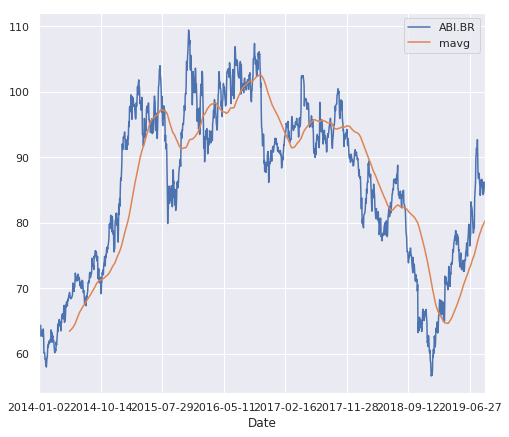

In [110]:
# Analize the data

# Rolling Mean
close_px = abi['Adj Close']
mavg = close_px.rolling(window=100).mean()

# Plot rolling mean vs Adj close

close_px.plot(label='ABI.BR')
mavg.plot(label='mavg')
plt.legend()


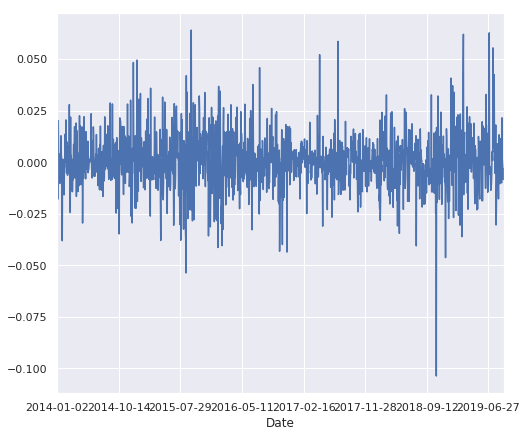

In [111]:
# Plot return deviation
rets = close_px / close_px.shift(1) - 1
rets.plot(label = 'Return')


# Step 2.

In [112]:
# Feature Engineering

# new datafram with features
abireg = df.loc[:, ['Adj Close', 'Volume']]
# Calculate High Low Percentage
abireg['HL_PCT'] = (abi['High'] - abi['Low']) / abi['Close'] * 100.0
# Calculate Percentage change
abireg['PCT_change'] = (abi['Close'] - abi['Open']) / df['Open'] * 100.0

abireg.head()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2014-01-02,63.048866,1442797,3.240319,-2.135647
2014-01-03,63.757664,675977,1.752556,1.432743
2014-01-06,62.615257,1060143,1.957654,-1.223364
2014-01-07,63.874405,1332194,2.480420,2.133331
2014-01-08,64.182945,1298308,1.429126,0.496155


In [0]:
# Pre-processing

# Drop missing value
abireg.fillna(value = -99999, inplace = True)

# Separate 1 % of the data to forecast
forecast_out = int(math.ceil(0.01 * len(abireg)))

# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
abireg['label'] = abireg[forecast_col].shift(-forecast_out)
X = np.array(abireg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution the regressions
X = scale(X)

# Finally we want to find data series of late X and early X (train)
# for model generation and evaluation
X_lately = X[-forecast_out : ]
X = X[ : -forecast_out]

# Separate label and identify it as y
y = np.array(abireg['label'])
y = y[ : -forecast_out]


In [114]:
# Prepare train and test variables
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    random_state=42)

# Import models

# Model 1 - Bayesian Ridge Regression
from sklearn.linear_model import BayesianRidge
clf_bayesian = BayesianRidge()
clf_bayesian.fit(X_train, y_train)

# Model 2 - Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor
clf_gboost = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, 
                                       max_depth=1, random_state=0, loss='ls')
clf_gboost.fit(X_train, y_train)

# Model 3 - Multi-layer Perceptron regressor
from sklearn.neural_network import MLPRegressor
clf_mlp = MLPRegressor(activation = 'logistic', max_iter = 2000)
clf_mlp.fit(X_train, y_train)


MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=2000, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [115]:
# Score non exaustive
print("The Bayesian Ridge regression confidence is:", 
      clf_bayesian.score(X_test, y_test))
print("The Gradient boosting regression confidence is:", 
      clf_gboost.score(X_test, y_test))
print("The Multi-layer Perceptron regression confidence is:", 
      clf_mlp.score(X_test, y_test))

The Bayesian Ridge regression confidence is: 0.8881244737098467
The Gradient boosting regression confidence is: 0.8872070265531018
The Multi-layer Perceptron regression confidence is: 0.8911644767540734


# Step 3.

In [0]:
# plot the predictions
forecast_set_bayesian = clf_bayesian.predict(X_lately)
forecast_set_gboost = clf_bayesian.predict(X_lately)
forecast_set_mlp = clf_bayesian.predict(X_lately)

abireg_bayesian = abireg.copy()
abireg_gboost = abireg.copy()
abireg_mlp = abireg.copy()

abireg_bayesian['Forecast Bayesian'] = np.nan
abireg_gboost['Forecast GBoost'] = np.nan
abireg_mlp['Forecast MLP'] = np.nan


In [0]:
# plot 1 - Forecast Bayesian

last_date = abireg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set_bayesian:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    abireg_bayesian.loc[next_date] = [np.nan for _ in range(len(abireg_bayesian.columns)-1)]+[i]


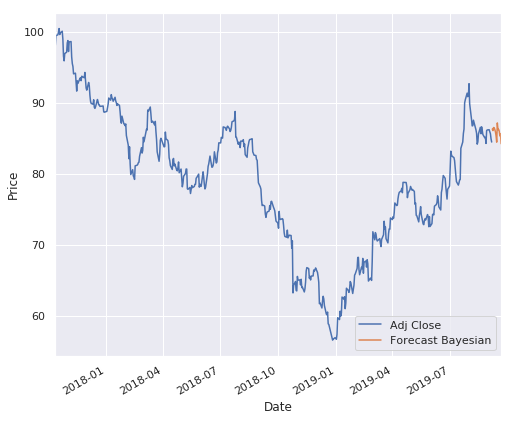

In [124]:
# Plot 1 - part 2
abireg_bayesian['Adj Close'].tail(500).plot()
abireg_bayesian['Forecast Bayesian'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [0]:
# plot 2 - Forecast Gradient boosting

last_date = abireg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set_gboost:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    abireg_gboost.loc[next_date] = [np.nan for _ in range(len(abireg_gboost.columns)-1)]+[i]


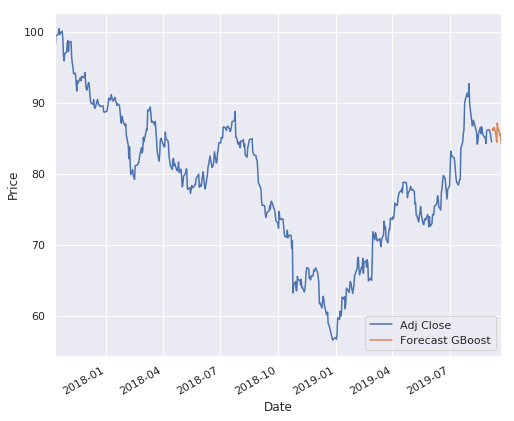

In [126]:
# Plot 2 - part 2
abireg_gboost['Adj Close'].tail(500).plot()
abireg_gboost['Forecast GBoost'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [0]:
# Plot 3 - Forecast Multi - layered Perceptron

last_date = abireg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set_mlp:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    abireg_mlp.loc[next_date] = [np.nan for _ in range(len(abireg_mlp.columns)-1)]+[i]


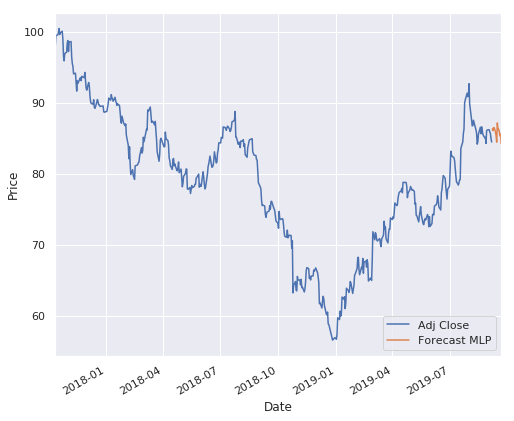

In [128]:
# Plot 3 - part 2
abireg_mlp['Adj Close'].tail(500).plot()
abireg_mlp['Forecast MLP'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()